In [1]:
import re
import itertools
import numpy as np 
import pandas as pd 
import seaborn as sns
import tensorflow as tf
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix

In [2]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout, SpatialDropout1D

In [3]:
data = pd.read_csv("/Users/harshsamant/Downloads/Tweets.csv")
df = data[["text","airline_sentiment"]]
df['text'] = df['text'].map(lambda x: x.lstrip('@VirginAmerica@UnitedAir@Southwestairline@DeltaAir@USAirways@American').rstrip('@'))
df.head()

/var/folders/ky/c51f6gc91rz5xnx9z_57tq380000gn/T/ipykernel_5757/2269042837.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['text'] = df['text'].map(lambda x: x.lstrip('@VirginAmerica@UnitedAir@Southwestairline@DeltaAir@USAirways@American').rstrip('@'))


,text,airline_sentiment
0,What @dhepburn said.,neutral
1,plus you've added commercials to the experien...,positive
2,I didn't today... Must mean I need to take an...,neutral
3,"it's really aggressive to blast obnoxious ""en...",negative
4,and it's a really big bad thing about it,negative


<Axes: xlabel='count', ylabel='airline'>

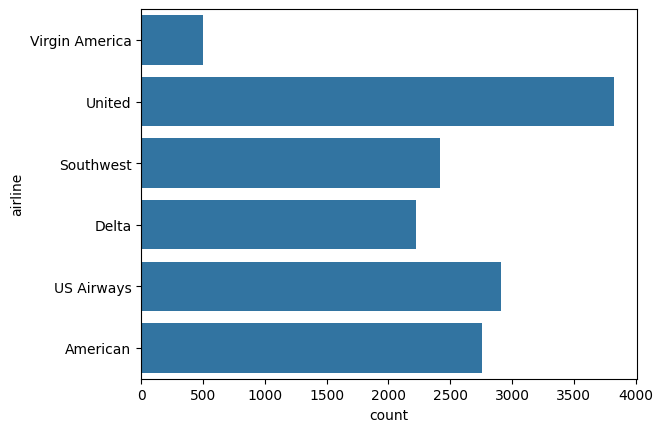

In [4]:
sns.countplot(data.airline)

In [5]:
df = df[df.airline_sentiment!="neutral"] # To remove neutral responses
df['text'] = df['text'].apply(lambda x: x.lower())
df['text'] = df['text'].apply((lambda x: re.sub('[^a-zA-z0-9\s]','',x))) # To keep numbers and strings only

<Axes: xlabel='count', ylabel='airline_sentiment'>

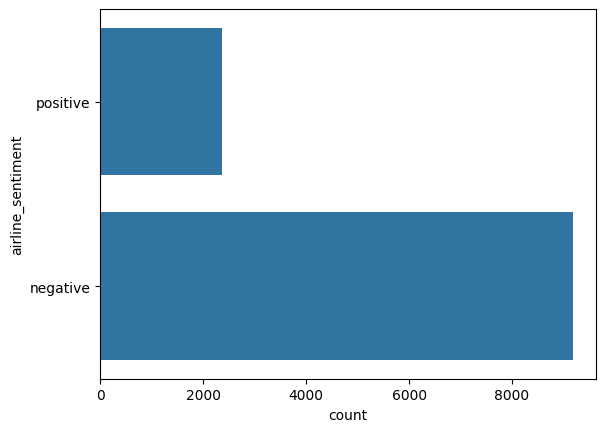

In [6]:
sns.countplot(df.airline_sentiment)

In [7]:
df = df.drop(df[df.airline_sentiment == "negative"].iloc[:6750].index)

<Axes: xlabel='count', ylabel='airline_sentiment'>

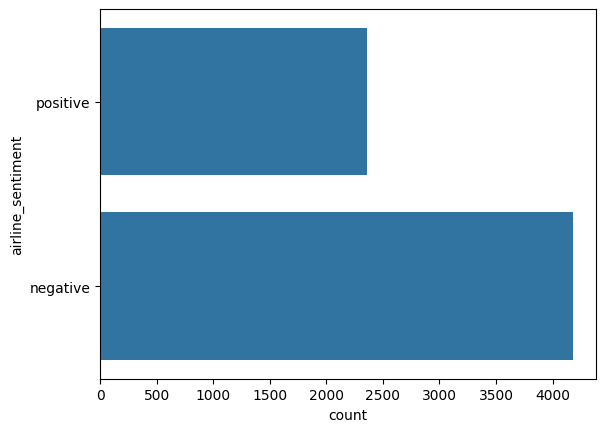

In [8]:
sns.countplot(df.airline_sentiment)

In [9]:
max_fatures = 4000
tokenizer = Tokenizer(num_words = max_fatures, split=' ')
tokenizer.fit_on_texts(df['text'].values)
X = pad_sequences(tokenizer.texts_to_sequences(df['text'].values))
Y = df['airline_sentiment'].values
X
Y

array(['positive', 'positive', 'positive', ..., 'positive', 'negative',
       'negative'], dtype=object)

In [10]:
k = []
for i in range(6541):
    if Y[i]=="negative":
        k.append(0)
    elif Y[i]=="positive":
        k.append(1)

In [11]:
X_train, X_test, Y_train, Y_test = train_test_split(X, k, test_size=0.3, shuffle = True, stratify = k, random_state = 1)

In [12]:
embed_dim = 128
lstm_out = 196
model = Sequential()
model.add(Embedding(max_fatures, embed_dim))
model.add(SpatialDropout1D(0.5))
model.add(LSTM(196, dropout = 0.3, recurrent_dropout = 0.3, input_shape=(X_train.shape[1],)))
model.add(Dropout(0.2))
model.add(Dense(100, activation = tf.nn.relu))
model.add(Dropout(0.4))
model.add(Dense(2, activation = tf.nn.softmax))

2024-05-06 16:43:15.269246: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M3 Pro
2024-05-06 16:43:15.269290: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 18.00 GB
2024-05-06 16:43:15.269299: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 6.00 GB
2024-05-06 16:43:15.269496: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2024-05-06 16:43:15.269523: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)
/opt/miniconda3/envs/tensorflow/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:205: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Se

In [13]:
model.compile(optimizer="adam", loss="sparse_categorical_crossentropy", metrics=["accuracy"])

In [24]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding (Embedding)           │ (None, 31, 128)        │       512,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ spatial_dropout1d               │ (None, 31, 128)        │             0 │
│ (SpatialDropout1D)              │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm (LSTM)                     │ (None, 196)            │       254,800 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 196)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 100)            │        19,700 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 100)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 2)              │           202 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,360,108 (9.00 MB)

 Trainable params: 786,702 (3.00 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 1,573,406 (6.00 MB)

In [19]:
X_train, Y_train = np.array(X_train), np.array(Y_train)
X_test, Y_test = np.array(X_test), np.array(Y_test)

In [16]:
history = model.fit(X_train, Y_train, epochs=20, batch_size=32, validation_split = 0.2, verbose = 1)

Epoch 1/20


2024-05-06 16:45:43.231701: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:117] Plugin optimizer for device_type GPU is enabled.


115/115 - 63s - 550ms/step - accuracy: 0.7698 - loss: 0.4781 - val_accuracy: 0.8526 - val_loss: 0.3295
Epoch 2/20
115/115 - 60s - 522ms/step - accuracy: 0.8971 - loss: 0.2637 - val_accuracy: 0.8974 - val_loss: 0.2553
Epoch 3/20
115/115 - 62s - 537ms/step - accuracy: 0.9323 - loss: 0.1786 - val_accuracy: 0.9127 - val_loss: 0.2335
Epoch 4/20
115/115 - 60s - 522ms/step - accuracy: 0.9563 - loss: 0.1331 - val_accuracy: 0.9148 - val_loss: 0.2503
Epoch 5/20
115/115 - 60s - 518ms/step - accuracy: 0.9694 - loss: 0.0906 - val_accuracy: 0.9127 - val_loss: 0.2557
Epoch 6/20
115/115 - 60s - 524ms/step - accuracy: 0.9762 - loss: 0.0790 - val_accuracy: 0.9094 - val_loss: 0.2794
Epoch 7/20
115/115 - 61s - 528ms/step - accuracy: 0.9820 - loss: 0.0548 - val_accuracy: 0.9061 - val_loss: 0.2698
Epoch 8/20
115/115 - 61s - 527ms/step - accuracy: 0.9820 - loss: 0.0571 - val_accuracy: 0.8985 - val_loss: 0.2946
Epoch 9/20
115/115 - 60s - 522ms/step - accuracy: 0.9880 - loss: 0.0386 - val_accuracy: 0.9127 - va

In [20]:
score = model.evaluate(X_test,Y_test)

62/62 ━━━━━━━━━━━━━━━━━━━━ 3s 44ms/step - accuracy: 0.8936 - loss: 0.6232


In [21]:
print("accuracy:", score[1]*100)

accuracy: 89.50585722923279


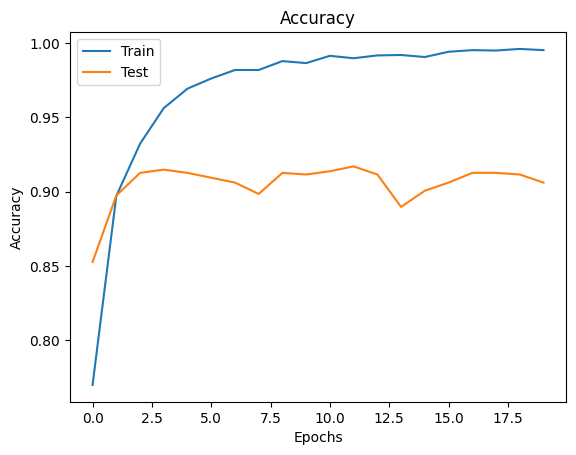

In [22]:
plt.figure()
plt.plot(history.history["accuracy"],label="Train");
plt.plot(history.history["val_accuracy"],label="Test");
plt.title("Accuracy")
plt.ylabel("Accuracy")
plt.xlabel("Epochs")
plt.legend()
plt.show()

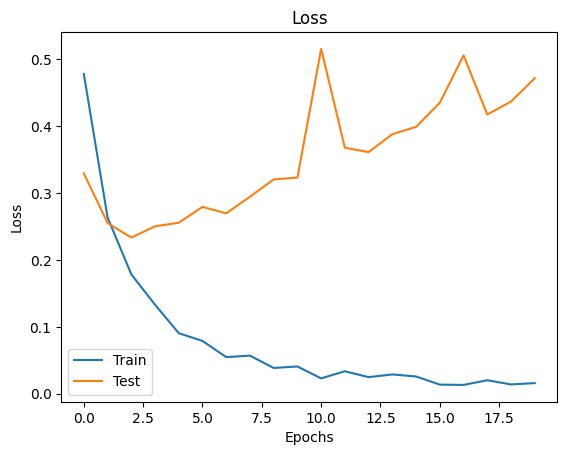

In [23]:
plt.figure()
plt.plot(history.history["loss"],label="Train");
plt.plot(history.history["val_loss"],label="Test");
plt.title("Loss")
plt.ylabel("Loss")
plt.xlabel("Epochs")
plt.legend()
plt.show()

In [27]:
sample = ['Meetings: Air crew is so dumb.', 'I love flying with Air India.']
sample = tokenizer.texts_to_sequences(sample)
sample = pad_sequences(sample, maxlen=31, dtype='int32', value=0)
print(sample)
sentiment1 = model.predict(sample,batch_size=1,verbose = 1)[0]
sentiment2 = model.predict(sample,batch_size=1,verbose = 1)[1]
if(np.argmax(sentiment1) == 0):
    print("Sentiment: Negative")
elif (np.argmax(sentiment1) == 1):
    print("Sentiment: Positive")

if(np.argmax(sentiment2) == 0):
    print("Sentiment: Negative")
elif (np.argmax(sentiment2) == 1):
    print("Sentiment: Positive")

[[   0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0 2030  237  147
    11   40 2049]
 [   0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    3  110
   140   23  237]]
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
Sentiment: Negative
Sentiment: Positive
